# precompute=T then F


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from random import sample

In [3]:
torch.cuda.set_device(1)
PATH = "data/drugs2/pics/"
sz = 224
arch = resnext101_64
bs = 200

## Initial model

In [4]:
def get_data(sz, bs, val_idxs, label_csv): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv,
                                       val_idxs=val_idxs, suffix='.png', tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time


### Precompute = F, testing dropouts

In [5]:
def kfld_loop3(k, epochs, name, precomp, bs, dropouts, label_csv, n):
    validation_accuracy = []
    for do in dropouts:
        for reps in range(k):
            val_idxs = get_cv_idxs(n, seed=random.sample(range(1000), 1)) # random 20% data for validation set
            data = get_data(sz, bs, val_idxs, label_csv)
            print('dropout='+str(do))
            learn = ConvLearner.pretrained(arch, data, precompute=precomp, ps = do)
            val_loss, val_acc = learn.fit(1e-2, epochs)
            validation_accuracy.append(val_acc)
            learn.save(str(reps)+'_DO_'+str(do)+name)
    return validation_accuracy, learn

### 3-class, testing dropouts

In [7]:
label_csv = f'{PATH}5labels.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n, seed=random.sample(range(1000), 1))
data = get_data(sz, bs, val_idxs, label_csv)
learn5 = ConvLearner.pretrained(arch, data, precompute=True, ps = 0.2)


epoch      trn_loss   val_loss   accuracy                 
    0      1.407791   1.223355   0.505817  
    1      1.207939   1.148773   0.538504                 
    2      1.116      1.109407   0.555125                 
    3      1.047501   1.102384   0.568975                 
    4      0.983114   1.054575   0.576177                 
    5      0.928545   1.040219   0.574515                  
    6      0.885943   1.030758   0.603324                  
    7      0.851791   1.023538   0.601662                  
    8      0.813639   1.016968   0.601108                  
    9      0.783929   1.02619    0.612742                  
    10     0.755137   1.019078   0.60277                   
    11     0.73928    1.001652   0.607756                  
    12     0.708923   1.001565   0.598892                  
    13     0.686529   1.009206   0.607202                  
    14     0.660161   1.015776   0.614958                  
    15     0.647457   0.998438   0.614958                  
 

   135     0.24663    1.361012   0.628809                  
   136     0.250727   1.346276   0.627147                  
   137     0.250185   1.3266     0.625485                  
   138     0.247914   1.321586   0.625485                  
   139     0.248594   1.334683   0.621053                  
   140     0.245947   1.340573   0.617175                  
   141     0.247088   1.357107   0.615512                  
   142     0.256996   1.334824   0.626039                  
   143     0.249253   1.350659   0.624931                  
   144     0.243047   1.383204   0.623269                  
   145     0.237656   1.363766   0.624377                  
   146     0.238937   1.338641   0.624931                  
   147     0.245729   1.34806    0.620499                  
   148     0.245261   1.348041   0.623269                  
   149     0.250651   1.351554   0.618837                  
   150     0.241373   1.343461   0.623823                  
   151     0.238708   1.350392   0.61828

   271     0.204671   1.442157   0.629363                  
   272     0.200225   1.444499   0.630471                  
   273     0.198683   1.456312   0.633241                  
   274     0.196912   1.446197   0.633795                  
   275     0.199911   1.446832   0.635457                  
   276     0.197713   1.436845   0.630471                  
   277     0.202727   1.443118   0.637119                  
   278     0.205802   1.431847   0.636565                  
   279     0.207309   1.455286   0.631579                  
   280     0.204471   1.436892   0.629917                  
   281     0.200017   1.41081    0.632133                  
   282     0.197642   1.436425   0.629363                  
   283     0.198436   1.426939   0.629917                  
   284     0.195619   1.448906   0.626593                  
   285     0.204291   1.428471   0.628809                  
   286     0.20108    1.430119   0.629363                  
   287     0.20273    1.432481   0.63268

   407     0.186652   1.476609   0.624377                  
   408     0.191644   1.459994   0.627701                  
   409     0.198321   1.477981   0.626039                  
   410     0.195368   1.455788   0.628809                  
   411     0.19585    1.450111   0.629917                  
   412     0.20204    1.439534   0.632133                  
   413     0.193437   1.428961   0.632133                  
   414     0.189791   1.443999   0.634349                  
   415     0.186531   1.448776   0.630471                  
   416     0.181281   1.445668   0.628809                  
   417     0.18637    1.454877   0.627147                  
   418     0.19278    1.439291   0.631579                  
   419     0.187961   1.455486   0.629363                  
   420     0.188818   1.44979    0.623823                  
   421     0.189784   1.482472   0.627701                  
   422     0.184415   1.487451   0.629917                  
   423     0.188136   1.471533   0.63213

   543     0.172103   1.533415   0.629917                  
   544     0.169136   1.532414   0.636565                  
   545     0.176332   1.546879   0.636011                  
   546     0.176954   1.544896   0.627701                  
   547     0.187281   1.515236   0.628255                  
   548     0.184526   1.526987   0.623269                  
   549     0.187002   1.538341   0.628255                  
   550     0.181099   1.507115   0.629917                  
   551     0.181107   1.533753   0.631025                  
   552     0.184806   1.52238    0.627147                  
   553     0.180706   1.529159   0.625485                  
   554     0.180871   1.524727   0.632133                  
   555     0.17752    1.543963   0.631025                  
   556     0.177613   1.521046   0.626593                  
   557     0.178582   1.520682   0.626593                  
   558     0.177148   1.524042   0.628809                  
   559     0.175034   1.523258   0.62825

   679     0.171401   1.569273   0.628255                  
   680     0.172965   1.589803   0.633241                  
   681     0.181621   1.589101   0.630471                  
   682     0.175584   1.563127   0.630471                  
   683     0.175082   1.569259   0.631579                  
   684     0.171239   1.567521   0.630471                  
   685     0.175409   1.572492   0.624931                  
   686     0.174811   1.546174   0.632133                  
   687     0.172872   1.562157   0.631579                  
   688     0.174294   1.570578   0.634349                  
   689     0.173646   1.556275   0.633241                  
   690     0.170962   1.556435   0.634903                  
   691     0.167544   1.552072   0.631579                  
   692     0.167431   1.554529   0.627147                  
   693     0.16976    1.577305   0.626039                  
   694     0.173632   1.562938   0.627147                  
   695     0.174178   1.563484   0.62714

   815     0.16807    1.553762   0.628809                  
   816     0.167237   1.550717   0.632687                  
   817     0.172972   1.564334   0.629363                  
   818     0.177976   1.582243   0.626039                  
   819     0.174252   1.567202   0.629917                  
   820     0.170524   1.580621   0.631579                  
   821     0.171508   1.593114   0.631025                  
   822     0.171307   1.577918   0.627701                  
   823     0.166217   1.575684   0.628255                  
   824     0.163593   1.58926    0.633241                  
   825     0.160815   1.595052   0.633241                  
   826     0.1614     1.604824   0.631025                  
   827     0.161169   1.605148   0.626039                  
   828     0.168707   1.601373   0.630471                  
   829     0.174535   1.591766   0.632687                  
   830     0.16696    1.615135   0.629917                  
   831     0.171231   1.619288   0.62825

   951     0.164137   1.635093   0.626039                  
   952     0.158369   1.635247   0.623823                  
   953     0.159229   1.658631   0.622161                  
   954     0.158048   1.649389   0.628255                  
   955     0.161305   1.661994   0.622715                  
   956     0.161181   1.662558   0.623269                  
   957     0.172034   1.633831   0.620499                  
   958     0.164835   1.634691   0.626039                  
   959     0.163382   1.628109   0.624377                  
   960     0.168486   1.650287   0.624931                  
   961     0.172281   1.624589   0.624931                  
   962     0.177826   1.644527   0.616621                  
   963     0.176694   1.605251   0.624931                  
   964     0.182403   1.627471   0.626593                  
   965     0.18197    1.618335   0.626039                  
   966     0.178373   1.623744   0.623823                  
   967     0.172894   1.601902   0.62216

[array([1.60893]), 0.6282548445413647]

In [13]:
learn.fit(1e-2, 1000)
learn.precompute = False
val_loss, val_acc = learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.80117    0.38425    0.854848  
    1      0.769391   0.372719   0.854848                  



[[0.9  0.06 0.02 0.01 0.01]                  
 [0.13 0.81 0.03 0.02 0.01]
 [0.05 0.02 0.83 0.09 0.01]
 [0.02 0.03 0.09 0.84 0.02]
 [0.05 0.05 0.07 0.17 0.66]]


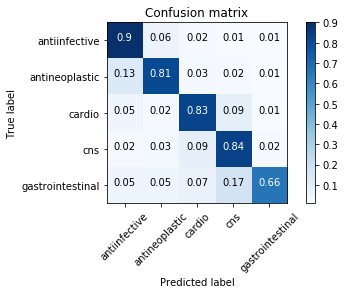

In [9]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
adj = cm.transpose()/cm.sum(axis=1)
adj = adj.round(2)
plot_confusion_matrix(adj.transpose(), data.classes)

In [10]:
learn.save('5class_86pctAcc')

## 3-classs

In [65]:
label_csv = f'{PATH}3labels.csv'
n = len(list(open(label_csv))) - 1
vacc =[]
reps=5
for rep in range(reps):
    val_idxs = get_cv_idxs(n, seed=random.sample(range(1000), 1))
    data3 = get_data(sz, bs, val_idxs, label_csv)
    learn3 = ConvLearner.pretrained(arch, data3, precompute=True, ps = 0.2)
    #lrf=learn3.lr_find(1e-6,10)
    #learn3.sched.plot()
    learn3.fit(1e-2, 50)
    learn3.precompute = False
    val_loss, val_acc = learn3.fit(1e-2, 1)
    vacc.append(val_acc)
#lrf=learn3.lr_find(1e-9,10)

epoch      trn_loss   val_loss   accuracy                
    0      1.028125   0.923016   0.567442  
    1      0.894474   0.830859   0.624186                
    2      0.8178     0.798152   0.648372                 
    3      0.755856   0.770429   0.683721                 
    4      0.70618    0.804354   0.670698                 
    5      0.665059   0.73825    0.695814                 
    6      0.622761   0.728392   0.710698                 
    7      0.58439    0.735244   0.715349                 
    8      0.557876   0.718437   0.713488                 
    9      0.533255   0.72237    0.712558                  
    10     0.506495   0.70938    0.726512                  
    11     0.481238   0.713204   0.724651                 
    12     0.460287   0.722206   0.722791                  
    13     0.442628   0.730683   0.729302                  
    14     0.423683   0.729136   0.71907                  
    15     0.405955   0.734955   0.732093                 
    16    

epoch      trn_loss   val_loss   accuracy                  
    0      0.72571    0.256109   0.903256  


In [66]:
print(np.mean(vacc))
print(np.std(vacc))

0.9032558244328166
0.0


[[0.92 0.05 0.04]                            
 [0.07 0.82 0.11]
 [0.06 0.09 0.85]]


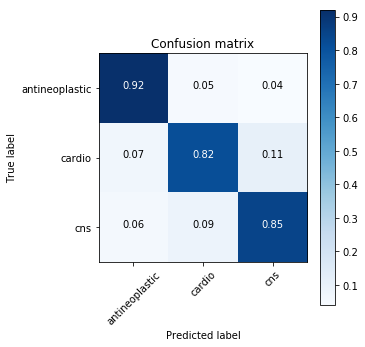

In [67]:
plt.rcParams['figure.figsize'] = [5, 5]
log_preds,y = learn3.TTA()
probs = np.mean(np.exp(log_preds),0)

preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
adj = cm.transpose()/cm.sum(axis=1)
adj = adj.round(2)
plot_confusion_matrix(adj.transpose(), data3.classes)

In [54]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1
vacc =[]
reps=1
for rep in range(reps):
    val_idxs = get_cv_idxs(n, seed=random.sample(range(1000), 1))
    data12 = get_data(sz, bs, val_idxs, label_csv)
    learn12 = ConvLearner.pretrained(arch, data12, precompute=True, ps = 0.2)
    #lrf=learn3.lr_find(1e-6,10)
    #learn3.sched.plot()
    learn12.fit(1e-2, 80)
    learn12.precompute = False
    val_loss, val_acc = learn12.fit(1e-2, 1)
    vacc.append(val_acc)
#lrf=learn3.lr_find(1e-9,10)

epoch      trn_loss   val_loss   accuracy                 
    0      2.06971    1.766299   0.426872  
    1      1.760046   1.642587   0.462555                 
    2      1.585652   1.551375   0.489868                 
    3      1.461677   1.514532   0.494273                 
    4      1.369123   1.460752   0.510132                 
    5      1.292656   1.446941   0.521586                 
    6      1.234018   1.461585   0.510573                 
    7      1.178178   1.435854   0.518062                 
    8      1.128714   1.417772   0.537445                 
    9      1.085267   1.402355   0.534361                 
    10     1.044509   1.408655   0.529956                 
    11     1.01097    1.411556   0.542731                 
    12     0.98047    1.404969   0.548899                  
    13     0.953286   1.428946   0.536123                  
    14     0.918258   1.406781   0.548018                  
    15     0.903391   1.418691   0.545374                  
    16  

epoch      trn_loss   val_loss   accuracy                  
    0      1.282391   0.594265   0.795595  


epoch      trn_loss   val_loss   accuracy                 
    0      2.061728   1.795786   0.426432  
    1      1.755395   1.685698   0.46652                  
    2      1.587559   1.635655   0.469604                 
    3      1.474907   1.608113   0.48326                  
    4      1.397089   1.596948   0.496035                 
    5      1.319976   1.595817   0.49163                  
    6      1.256806   1.592384   0.502203                 
    7      1.202187   1.580602   0.505286                 
    8      1.14933    1.595931   0.495595                 
    9      1.100989   1.577221   0.507489                 
    10     1.071483   1.594498   0.512335                 
    11     1.028961   1.594366   0.515859                 
    12     1.00204    1.600171   0.523348                  
    13     0.978332   1.610342   0.514978                  
    14     0.952719   1.603338   0.50793                   
    15     0.930874   1.622043   0.513216                  
    16  

epoch      trn_loss   val_loss   accuracy                  
    0      1.258289   0.672588   0.763436  


epoch      trn_loss   val_loss   accuracy                 
    0      2.081045   1.785898   0.44185   
    1      1.760655   1.658731   0.457269                 
    2      1.590812   1.602424   0.478414                 
    3      1.473798   1.569339   0.481498                 
    4      1.391232   1.537294   0.502203                 
    5      1.314886   1.531841   0.5                      
    6      1.252007   1.531006   0.511454                 
    7      1.192314   1.507144   0.515419                 
    8      1.143816   1.516268   0.519824                 
    9      1.103477   1.502394   0.520264                 
    10     1.061859   1.5105     0.519383                 
    11     1.038099   1.514359   0.521586                 
    12     1.000619   1.512512   0.531718                  
    13     0.968713   1.52422    0.525551                  
    14     0.944485   1.550964   0.523789                  
    15     0.915713   1.53389    0.528194                  
    16  

epoch      trn_loss   val_loss   accuracy                  
    0      1.282355   0.612492   0.785022  


epoch      trn_loss   val_loss   accuracy                 
    0      2.097243   1.753407   0.422467  
    1      1.77459    1.618782   0.463877                 
    2      1.60266    1.570686   0.474449                 
    3      1.473488   1.535243   0.494714                 
    4      1.378437   1.527113   0.495154                 
    5      1.305731   1.498263   0.504405                 
    6      1.239139   1.477901   0.514537                 
    7      1.185495   1.498745   0.507489                 
    8      1.146243   1.461416   0.52511                  
    9      1.107745   1.47727    0.520264                 
    10     1.068972   1.452259   0.528634                 
    11     1.034247   1.481345   0.53348                  
    12     0.995607   1.480951   0.518943                  
    13     0.967352   1.470302   0.52511                   
    14     0.939357   1.4983     0.522026                  
    15     0.912279   1.474806   0.530837                  
    16  

epoch      trn_loss   val_loss   accuracy                  
    0      1.262129   0.584096   0.781938  


epoch      trn_loss   val_loss   accuracy                 
    0      2.075648   1.735327   0.430837  
    1      1.752687   1.567021   0.470044                 
    2      1.576107   1.516267   0.495154                 
    3      1.453067   1.460351   0.507489                 
    4      1.359282   1.425666   0.512775                 
    5      1.290293   1.390877   0.52511                  
    6      1.216117   1.37843    0.531718                 
    7      1.158731   1.370648   0.537885                 
    8      1.117834   1.341147   0.543612                 
    9      1.084193   1.357706   0.547137                 
    10     1.04471    1.33363    0.553744                 
    11     1.00111    1.336209   0.552423                 
    12     0.967954   1.307748   0.554185                  
    13     0.934794   1.317956   0.552863                  
    14     0.904897   1.307906   0.568722                  
    15     0.884096   1.333043   0.550661                  
    16  

epoch      trn_loss   val_loss   accuracy                  
    0      1.255307   0.577794   0.787225  


In [55]:
print(np.mean(vacc))
print(np.std(vacc))

0.7826431738122445
0.010618841127250402


In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
log_preds,y = learn3.TTA()
probs = np.mean(np.exp(log_preds),0)

preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
adj = cm.transpose()/cm.sum(axis=1)
adj = adj.round(2)
plot_confusion_matrix(adj.transpose(), data3.classes)

## 5-class
  

In [10]:
label_csv = f'{PATH}5labels.csv'
n = len(list(open(label_csv))) - 1
vacc =[]
reps=5
for rep in range(reps):
    val_idxs = get_cv_idxs(n, seed=random.sample(range(1000), 1))
    data5 = get_data(sz, bs, val_idxs, label_csv)
    learn5 = ConvLearner.pretrained(arch, data5, precompute=True, ps = 0.2)
    #lrf=learn3.lr_find(1e-6,10)
    #learn3.sched.plot()
    learn5.fit(1e-2, 80)
    learn5.precompute = False
    val_loss, val_acc = learn5.fit(1e-2, 1)
    vacc.append(val_acc)
#lrf=learn3.lr_find(1e-9,10)
print(np.mean(vacc))
print(np.std(vacc))

epoch      trn_loss   val_loss   accuracy                 
    0      1.42497    1.169546   0.531302  
    1      1.229321   1.09283    0.573961                 
    2      1.12997    1.054204   0.573961                 
    3      1.038825   1.014063   0.592798                 
    4      0.973951   1.005085   0.603324                  
    5      0.925179   0.977274   0.60831                   
    6      0.875097   0.976585   0.61385                   
    7      0.831286   0.973784   0.624377                  
    8      0.801342   0.961254   0.628809                  
    9      0.771943   0.967243   0.633795                  
    10     0.750462   1.00188    0.622715                  
    11     0.718751   0.977237   0.630471                  
    12     0.688838   0.954529   0.640997                  
    13     0.666919   0.954334   0.633241                  
    14     0.661654   0.950935   0.640997                  
    15     0.648063   0.978371   0.635457                  


epoch      trn_loss   val_loss   accuracy                  
    0      0.929813   0.401703   0.86482   



epoch      trn_loss   val_loss   accuracy                 
    0      1.412194   1.198569   0.522992  
    1      1.223744   1.112899   0.555679                 
    2      1.115489   1.068825   0.573407                 
    3      1.035969   1.047163   0.606094                 
    4      0.973722   1.036431   0.582825                  
    5      0.932949   1.040126   0.599446                  
    6      0.898922   1.011249   0.613296                  
    7      0.855609   1.025993   0.616066                  
    8      0.819141   1.012049   0.609418                  
    9      0.787115   0.989778   0.622161                  
    10     0.760138   1.007121   0.621053                  
    11     0.732377   0.990125   0.624931                  
    12     0.703001   1.01453    0.619391                  
    13     0.685357   1.006867   0.624377                  
    14     0.665349   1.02689    0.622715                  
    15     0.643158   1.009756   0.633241                  


epoch      trn_loss   val_loss   accuracy                  
    0      0.924083   0.370779   0.85097   



epoch      trn_loss   val_loss   accuracy                 
    0      1.429689   1.162036   0.536288  
    1      1.224177   1.078683   0.567313                 
    2      1.111099   1.03352    0.583934                 
    3      1.036597   1.017912   0.59169                  
    4      0.974851   0.990602   0.612188                  
    5      0.92067    0.971769   0.612742                  
    6      0.879824   0.95872    0.619391                  
    7      0.844166   0.956747   0.629363                  
    8      0.805343   0.951952   0.621053                  
    9      0.77648    0.981513   0.626039                  
    10     0.754122   0.977977   0.628255                  
    11     0.733219   0.921964   0.634349                  
    12     0.71301    0.950574   0.647645                  
    13     0.688313   0.937593   0.645429                  
    14     0.667231   0.946213   0.637673                  
    15     0.637537   0.936818   0.641551                  


epoch      trn_loss   val_loss   accuracy                  
    0      0.910183   0.375534   0.845983  



epoch      trn_loss   val_loss   accuracy                 
    0      1.395116   1.178383   0.531302  
    1      1.219918   1.105429   0.562881                 
    2      1.11928    1.066785   0.582271                 
    3      1.040254   1.046407   0.58615                  
    4      0.994505   1.021475   0.59723                   
    5      0.938706   1.028119   0.601108                  
    6      0.899046   1.035055   0.609972                  
    7      0.849334   1.001971   0.61108                   
    8      0.815074   0.99998    0.621607                  
    9      0.784653   1.001286   0.623269                  
    10     0.758871   0.992234   0.623269                  
    11     0.729219   1.009683   0.624377                  
    12     0.712347   1.016913   0.624931                  
    13     0.697688   0.998736   0.622161                  
    14     0.687145   0.998161   0.631025                  
    15     0.669628   1.014446   0.622161                  


epoch      trn_loss   val_loss   accuracy                  
    0      0.930055   0.392607   0.844875  



epoch      trn_loss   val_loss   accuracy                 
    0      1.384506   1.153186   0.532964  
    1      1.212089   1.076495   0.564543                 
    2      1.128055   1.04574    0.583379                 
    3      1.048112   1.026511   0.593906                 
    4      0.988016   1.001281   0.607202                  
    5      0.928224   0.995154   0.622161                  
    6      0.872303   0.979979   0.622715                  
    7      0.836535   0.979482   0.620499                  
    8      0.803444   0.961107   0.637673                  
    9      0.774346   0.963116   0.634349                  
    10     0.759471   0.957151   0.641551                  
    11     0.725286   0.961418   0.638227                  
    12     0.708755   0.93569    0.643213                  
    13     0.681668   0.943194   0.640443                  
    14     0.666023   0.972      0.634349                  
    15     0.657869   0.950371   0.634349                  


epoch      trn_loss   val_loss   accuracy                  
    0      0.907114   0.402468   0.843767  

0.8500831028100857
0.007768881039224904


In [58]:
print(np.mean(vacc))
print(np.std(vacc))

0.843767313580764
0.005671575782813434


[[0.84 0.08 0.04 0.03 0.01]                  
 [0.11 0.79 0.04 0.03 0.01]
 [0.03 0.03 0.81 0.12 0.  ]
 [0.02 0.02 0.08 0.86 0.02]
 [0.04 0.02 0.06 0.27 0.6 ]]


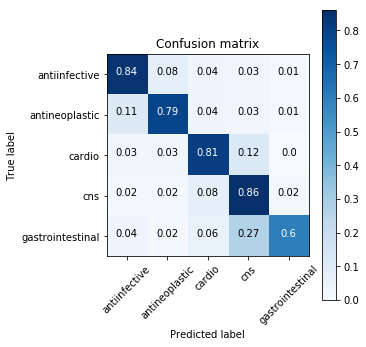

In [9]:
plt.rcParams['figure.figsize'] = [5, 5]
log_preds,y = learn5.TTA()
probs = np.mean(np.exp(log_preds),0)

preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
adj = cm.transpose()/cm.sum(axis=1)
adj = adj.round(2)
plot_confusion_matrix(adj.transpose(), data5.classes)

## 12 class, precompute=T, then false, then unfreeze early layers

In [14]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n, seed=random.sample(range(1000), 1))
data = get_data(sz, bs, val_idxs, label_csv)
learn12 = ConvLearner.pretrained(arch, data, precompute=True, ps = 0.2)
learn12.fit(1e-2, 200)


100%|██████████| 12/12 [00:20<00:00,  1.38s/it]


epoch      trn_loss   val_loss   accuracy                 
    0      2.032811   1.794492   0.407048  
    1      1.736068   1.605781   0.448899                 
    2      1.559224   1.520814   0.467841                 
    3      1.443779   1.464474   0.49207                  
    4      1.345518   1.440043   0.507489                 
    5      1.275196   1.389538   0.522026                 
    6      1.209192   1.359814   0.526872                 
    7      1.145864   1.339373   0.521145                 
    8      1.096367   1.32656    0.528194                 
    9      1.052433   1.323673   0.526432                 
    10     1.017301   1.307913   0.52511                  
    11     0.975453   1.308037   0.533921                  
    12     0.950404   1.30224    0.540969                  
    13     0.916672   1.280027   0.55022                   
    14     0.881787   1.305694   0.54978                   
    15     0.858536   1.325594   0.537445                  
    16 

   136     0.343225   1.679648   0.54141                   
   137     0.344796   1.683749   0.544493                  
   138     0.343337   1.670722   0.544053                  
   139     0.339586   1.688448   0.540088                  
   140     0.341864   1.682743   0.544934                  
   141     0.337374   1.68518    0.551982                  
   142     0.334818   1.688388   0.548018                  
   143     0.336977   1.690154   0.544493                  
   144     0.335386   1.692541   0.544493                  
   145     0.33492    1.702051   0.543172                  
   146     0.33501    1.686798   0.544934                  
   147     0.337137   1.714866   0.540969                  
   148     0.343846   1.686728   0.552423                  
   149     0.339509   1.693699   0.544053                  
   150     0.325421   1.695279   0.548458                  
   151     0.33009    1.688351   0.542731                  
   152     0.334118   1.693768   0.54669

[array([1.73136]), 0.5484581521429154]

In [15]:
learn12.precompute = False
val_loss, val_acc = learn12.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.995005   1.674127   0.547137  
    1      0.981991   1.609238   0.553744                  



In [ ]:
log_preds,y = learn12.TTA()
probs = np.mean(np.exp(log_preds),0)

preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
adj = cm.transpose()/cm.sum(axis=1)
adj = adj.round(2)
plot_confusion_matrix(adj.transpose(), data.classes)

In [6]:
dropouts = [0,0.2,0.4,0.5,0.6]
label_csv = f'{PATH}5labels.csv'
n = len(list(open(label_csv))) - 1
#dropouts = [0, 0, 0.2, 0.2]
v_a1, learn1 = kfld_loop3(3, 200, '_3cls_pf_200ep.model', False, 200, dropouts, label_csv, n) 
v_a2, learn2 = kfld_loop3(3, 500, '_3cls_pf_200ep.model', False, 200, dropouts, label_csv, n) 



dropout=0


epoch      trn_loss   val_loss   accuracy                 
    0      1.351154   1.205269   0.506925  
    1      1.180097   1.111439   0.542936                 
    2      1.077595   1.047404   0.577839                 
    3      1.017367   1.035693   0.570637                 
    4      0.961159   1.012975   0.590582                  
    5      0.905736   0.993671   0.598892                  
    6      0.884161   0.979979   0.602216                  
    7      0.849423   0.987245   0.607202                  
    8      0.813008   1.004718   0.608864                  
    9      0.793767   0.98756    0.597784                  
    10     0.761666   1.001628   0.609418                  
    11     0.751801   0.954475   0.619391                  
    12     0.733616   0.949089   0.627147                  
    13     0.715964   0.959277   0.642105                  
    14     0.705067   0.945306   0.624377                  
    15     0.689781   0.973974   0.636565                  


   135     0.303532   1.078764   0.686427                  
   136     0.31397    1.062164   0.672576                  
   137     0.306613   1.051761   0.676454                  
   138     0.306723   1.068705   0.666482                  
   139     0.300891   1.063959   0.669806                  
   140     0.309447   1.065982   0.677008                  
   141     0.301948   1.066802   0.669252                  
   142     0.293509   1.061185   0.674238                  
   143     0.295704   1.092141   0.66759                   
   144     0.29687    1.074323   0.667036                  
   145     0.287737   1.061355   0.670914                  
   146     0.285465   1.102027   0.675346                  
   147     0.289965   1.06871    0.669252                  
   148     0.288962   1.096386   0.668144                  
   149     0.292737   1.066285   0.674792                  
   150     0.297008   1.079361   0.680886                  
   151     0.29886    1.076613   0.68144


dropout=0


epoch      trn_loss   val_loss   accuracy                 
    0      1.355585   1.186845   0.520222  
    1      1.175654   1.102992   0.544598                 
    2      1.076179   1.055588   0.572853                 
    3      1.018614   1.025754   0.592244                 
    4      0.960315   1.025083   0.580609                  
    5      0.917994   0.983743   0.625485                  
    6      0.867884   0.985132   0.618283                  
    7      0.832758   0.977016   0.616066                  
    8      0.800838   0.96179    0.612742                  
    9      0.781683   0.945686   0.637673                  
    10     0.758908   0.957411   0.628255                  
    11     0.728326   0.964955   0.637673                  
    12     0.714099   0.955316   0.641551                  
    13     0.702583   0.927216   0.648753                  
    14     0.682466   0.955354   0.639889                  
    15     0.66021    0.933463   0.648753                  


   135     0.304864   0.979311   0.68144                   
   136     0.298242   0.98052    0.684211                  
   137     0.292281   0.99487    0.679224                  
   138     0.288817   1.015873   0.685319                  
   139     0.287161   1.031892   0.684211                  
   140     0.278852   1.019148   0.685319                  
   141     0.281563   0.990004   0.684765                  
   142     0.289575   1.015547   0.68144                   
   143     0.301838   1.050328   0.683657                  
   144     0.307643   0.98568    0.690859                  
   145     0.289468   0.972053   0.691413                  
   146     0.281877   0.991866   0.688643                  
   147     0.278929   0.979582   0.688643                  
   148     0.287795   0.97861    0.686981                  
   149     0.287278   1.008588   0.686981                  
   150     0.286867   1.003747   0.677562                  
   151     0.282308   1.004346   0.68587


dropout=0


epoch      trn_loss   val_loss   accuracy                 
    0      1.35204    1.192261   0.518006  
    1      1.189391   1.109155   0.554571                 
    2      1.094114   1.087779   0.560111                 
    3      1.022332   1.051953   0.592798                 
    4      0.962953   1.029739   0.587258                  
    5      0.925758   1.015493   0.598892                  
    6      0.889812   0.998809   0.614404                  
    7      0.858178   0.978511   0.616621                  
    8      0.816681   0.979643   0.624931                  
    9      0.785683   0.996029   0.622715                  
    10     0.769408   0.945062   0.639335                  
    11     0.755164   0.957911   0.619391                  
    12     0.72995    0.978325   0.636011                  
    13     0.705256   0.961553   0.642105                  
    14     0.677293   0.973828   0.640443                  
    15     0.666116   0.954322   0.651524                  


   135     0.295956   1.055574   0.690305                  
   136     0.296088   1.053147   0.690859                  
   137     0.299405   1.06094    0.691413                  
   138     0.301928   1.021276   0.696953                  
   139     0.310559   1.066077   0.691413                  
   140     0.309612   1.067531   0.687535                  
   141     0.310599   1.071198   0.689751                  
   142     0.31927    1.08054    0.686981                  
   143     0.311524   1.044939   0.689197                  
   144     0.307729   1.046085   0.688089                  
   145     0.305293   1.039591   0.693629                  
   146     0.304393   1.055086   0.690305                  
   147     0.294417   1.068952   0.694737                  
   148     0.285283   1.087706   0.693075                  
   149     0.284763   1.051659   0.68144                   
   150     0.28212    1.066846   0.700277                  
   151     0.284721   1.070317   0.69418


dropout=0.2


epoch      trn_loss   val_loss   accuracy                 
    0      1.414224   1.261176   0.493075  
    1      1.255934   1.165494   0.539058                 
    2      1.17718    1.127533   0.557895                 
    3      1.123647   1.103429   0.553463                 
    4      1.080977   1.091929   0.562881                 
    5      1.052019   1.070601   0.569529                 
    6      1.03493    1.04334    0.578947                 
    7      1.007769   1.015912   0.59723                  
    8      0.980961   1.01282    0.599446                  
    9      0.960035   1.002191   0.604432                  
    10     0.936893   0.98851    0.6                       
    11     0.927014   0.981329   0.606648                  
    12     0.912847   0.975862   0.602216                  
    13     0.908338   0.98514    0.601662                  
    14     0.891627   0.957037   0.614404                  
    15     0.877034   0.956927   0.617729                  
    

KeyboardInterrupt: 

In [48]:
v_a = k_fold_cross_loop1(10,100)

epoch      trn_loss   val_loss   accuracy                 
    0      2.070548   1.669185   0.429075  
    1      1.76888    1.556218   0.46652                  
    2      1.645123   1.498228   0.482379                  
    3      1.545225   1.455022   0.494273                  
    4      1.480391   1.424      0.497357                 
    5      1.422637   1.385548   0.511454                 
    6      1.381897   1.341969   0.517181                 
    7      1.324599   1.327606   0.532159                 
    8      1.290708   1.325242   0.532159                 
    9      1.267365   1.307441   0.54141                   
    10     1.229282   1.292712   0.534361                  
    11     1.208318   1.281906   0.547137                  
    12     1.167715   1.278463   0.546696                 
    13     1.14537    1.268767   0.548018                 
    14     1.109101   1.2657     0.548018                 
    15     1.101349   1.247311   0.562555                 
    16 

epoch      trn_loss   val_loss   accuracy                 
    0      2.082087   1.680048   0.448018  
    1      1.790978   1.573119   0.445815                 
    2      1.633364   1.496212   0.478414                 
    3      1.541974   1.448939   0.488987                 
    4      1.492486   1.421354   0.502203                 
    5      1.438499   1.395803   0.511894                 
    6      1.383618   1.377353   0.508811                 
    7      1.351633   1.365814   0.501762                 
    8      1.306841   1.33187    0.528634                 
    9      1.276673   1.331444   0.534361                 
    10     1.234611   1.311445   0.534361                 
    11     1.201428   1.3091     0.530396                 
    12     1.181753   1.291834   0.539207                 
    13     1.172887   1.275719   0.545815                 
    14     1.148957   1.282912   0.546696                 
    15     1.109257   1.271912   0.543172                 
    16     1

epoch      trn_loss   val_loss   accuracy                 
    0      2.075945   1.67589    0.43348   
    1      1.768355   1.555436   0.463436                 
    2      1.628673   1.482706   0.481938                 
    3      1.542327   1.453784   0.486784                 
    4      1.473394   1.400499   0.509692                 
    5      1.419219   1.368242   0.51674                  
    6      1.36255    1.365166   0.518502                 
    7      1.318509   1.335945   0.533921                 
    8      1.288755   1.330634   0.526432                 
    9      1.255152   1.320169   0.530396                 
    10     1.224379   1.296715   0.548018                 
    11     1.200319   1.280242   0.557709                 
    12     1.168186   1.265933   0.559912                 
    13     1.145757   1.264515   0.555947                 
    14     1.124273   1.275745   0.555066                 
    15     1.101011   1.265241   0.549339                 
    16     1

epoch      trn_loss   val_loss   accuracy                 
    0      2.058092   1.682293   0.431278  
    1      1.770803   1.590136   0.459912                 
    2      1.63962    1.517988   0.467401                 
    3      1.552602   1.463593   0.485022                 
    4      1.480642   1.419397   0.503084                 
    5      1.42187    1.393795   0.517621                 
    6      1.366614   1.363929   0.514097                 
    7      1.338306   1.355018   0.519824                 
    8      1.29881    1.330372   0.52511                  
    9      1.26282    1.338571   0.532159                 
    10     1.23036    1.306958   0.53304                  
    11     1.19982    1.294975   0.537445                 
    12     1.182761   1.296886   0.546696                 
    13     1.152609   1.266105   0.544493                 
    14     1.128042   1.264656   0.550661                 
    15     1.126551   1.258455   0.551542                 
    16     1

epoch      trn_loss   val_loss   accuracy                 
    0      2.075494   1.683606   0.424229  
    1      1.779713   1.578465   0.454626                 
    2      1.641441   1.512408   0.472687                 
    3      1.540287   1.453068   0.493833                 
    4      1.470331   1.439515   0.503524                 
    5      1.424656   1.390363   0.509251                 
    6      1.375353   1.372593   0.514097                 
    7      1.344349   1.346982   0.519383                 
    8      1.298948   1.339111   0.526872                 
    9      1.263226   1.330409   0.535242                 
    10     1.227147   1.311091   0.545374                 
    11     1.211222   1.303971   0.533921                 
    12     1.177912   1.291893   0.540088                 
    13     1.154132   1.288125   0.543172                 
    14     1.114563   1.26843    0.552423                  
    15     1.107407   1.26738    0.548458                  
    16    

epoch      trn_loss   val_loss   accuracy                 
    0      2.062443   1.663398   0.444493  
    1      1.776037   1.548098   0.463436                 
    2      1.638831   1.489166   0.476211                 
    3      1.545082   1.43153    0.493392                 
    4      1.470115   1.401145   0.504846                 
    5      1.410552   1.374518   0.519383                 
    6      1.352297   1.355153   0.515419                 
    7      1.322183   1.355286   0.520705                 
    8      1.287429   1.327886   0.52467                  
    9      1.243965   1.312452   0.537445                 
    10     1.227162   1.303163   0.528634                 
    11     1.190456   1.282146   0.539648                  
    12     1.169072   1.300047   0.543612                 
    13     1.163871   1.280539   0.54141                  
    14     1.13802    1.266065   0.54978                  
    15     1.102924   1.285507   0.540969                 
    16     

epoch      trn_loss   val_loss   accuracy                 
    0      2.063038   1.685731   0.414978  
    1      1.764446   1.562178   0.446256                 
    2      1.629279   1.484249   0.489868                 
    3      1.532227   1.438738   0.500881                 
    4      1.477964   1.408984   0.501322                  
    5      1.423282   1.376824   0.515419                 
    6      1.368953   1.359803   0.518502                 
    7      1.332311   1.32568    0.527313                 
    8      1.301508   1.331131   0.531278                 
    9      1.270664   1.316045   0.52511                  
    10     1.232052   1.309361   0.540969                 
    11     1.203517   1.283983   0.551542                 
    12     1.178116   1.283642   0.540969                 
    13     1.146628   1.274553   0.542291                 
    14     1.122978   1.273328   0.544493                 
    15     1.103877   1.254887   0.546256                 
    16     

epoch      trn_loss   val_loss   accuracy                 
    0      2.092233   1.66641    0.439207  
    1      1.77948    1.570702   0.466079                 
    2      1.640784   1.530033   0.473128                 
    3      1.553381   1.45206    0.505727                 
    4      1.483861   1.407587   0.502643                 
    5      1.408491   1.382125   0.514978                 
    6      1.369511   1.356664   0.518062                 
    7      1.335667   1.330133   0.526872                 
    8      1.297144   1.331242   0.530837                 
    9      1.26276    1.325361   0.535242                 
    10     1.226886   1.302318   0.543172                 
    11     1.19639    1.287066   0.537445                 
    12     1.179546   1.274258   0.551101                 
    13     1.142277   1.286925   0.542731                 
    14     1.119497   1.278839   0.552423                 
    15     1.113673   1.276885   0.543172                 
    16     1

epoch      trn_loss   val_loss   accuracy                 
    0      2.073422   1.672556   0.421145  
    1      1.78585    1.555015   0.467401                  
    2      1.6399     1.500961   0.480176                 
    3      1.535749   1.469025   0.496035                 
    4      1.471203   1.413403   0.505286                 
    5      1.416234   1.393401   0.5163                   
    6      1.371151   1.362424   0.518943                 
    7      1.333243   1.342789   0.515859                 
    8      1.297632   1.323096   0.525551                 
    9      1.261791   1.310451   0.527313                 
    10     1.246923   1.316659   0.530396                  
    11     1.202701   1.285658   0.542731                 
    12     1.176799   1.281872   0.531718                 
    13     1.150727   1.283171   0.559031                 
    14     1.13559    1.270559   0.54185                  
    15     1.115756   1.252159   0.556388                 
    16    

epoch      trn_loss   val_loss   accuracy                 
    0      2.079844   1.667367   0.437885  
    1      1.78055    1.552633   0.460352                 
    2      1.629926   1.490917   0.473128                 
    3      1.545215   1.448304   0.486344                 
    4      1.472309   1.40425    0.501762                 
    5      1.414946   1.394346   0.512775                 
    6      1.36355    1.383962   0.5163                   
    7      1.319522   1.321849   0.523348                 
    8      1.275387   1.317617   0.534802                 
    9      1.250435   1.306414   0.537445                 
    10     1.23389    1.315801   0.537445                 
    11     1.198433   1.29526    0.53348                  
    12     1.172579   1.276422   0.551982                 
    13     1.13823    1.261909   0.548458                 
    14     1.134498   1.275434   0.551542                 
    15     1.109187   1.265567   0.55815                  
    16     1

In [60]:
valacc = [0.581498,0.57709,0.58239,0.580176,0.578855,0.580617,0.57577,0.5837,0.57665,0.5797]
print('mean='+str(np.mean(valacc)))
print('stdev.='+str(np.std(valacc)))

mean=0.5796446
stdev.=0.0024449785765932545


In [1]:
plt.rcParams['figure.figsize'] = [10, 10]

NameError: name 'plt' is not defined

In [2]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
adj = cm.transpose()/cm.sum(axis=1)
adj = adj.round(2)
plot_confusion_matrix(adj.transpose(), data.classes)

NameError: name 'learn' is not defined

### Augment

In [22]:
from sklearn import metrics

In [23]:
data = get_data(sz, bs)

In [24]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

100%|██████████| 18/18 [00:19<00:00,  1.01it/s]


In [26]:
learn.fit(1e-2, 200)

epoch      trn_loss   val_loss   accuracy                 
    0      1.267667   1.289242   0.543172  
    1      1.24221    1.293281   0.544493                 
    2      1.233481   1.27629    0.540529                 
    3      1.23161    1.271877   0.543612                 
    4      1.236873   1.275465   0.537004                 
    5      1.217533   1.269105   0.551101                 
    6      1.2        1.257847   0.548458                 
    7      1.175196   1.259171   0.55022                  
    8      1.167488   1.250896   0.544934                 
    9      1.15592    1.278416   0.550661                 
    10     1.157006   1.253423   0.552863                 
    11     1.15742    1.253472   0.551101                  
    12     1.147838   1.252431   0.555947                 
    13     1.123004   1.244008   0.548458                 
    14     1.11987    1.241218   0.546256                  
    15     1.115705   1.247234   0.555066                  
    16   

[array([1.37358]), 0.5607929516468805]

In [34]:
learn.precompute = False

In [1]:
learn.fit(1e-2, 100, cycle_len=1)

NameError: name 'learn' is not defined

In [36]:
learn.save('224_preF_b58')

In [31]:
learn.load('224_preF_b58')

## Find the learning rate

## Increase size

In [33]:
# Starting training on small images for a few epochs, then switching to bigger images, and continuing training is an amazingly effective way to avoid overfitting.

# http://forums.fast.ai/t/planet-classification-challenge/7824/96
# set_data doesn’t change the model at all. It just gives it new data to train with.
learn.set_data(get_data(299, 80)) 
learn.freeze()

#Source:   
#    def set_data(self, data, precompute=False):
#        super().set_data(data)
#        if precompute:
#            self.unfreeze()
#            self.save_fc1()
#            self.freeze()
#            self.precompute = True
#        else:
#            self.freeze()
#File:      ~/fastai/courses/dl1/fastai/conv_learner.py

In [34]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 299, 299]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 75, 

In [35]:
learn.freeze()

In [43]:
learn.fit(5e-3, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.626417   1.426835   0.503524  
    1      1.595296   1.415666   0.511013                   
    2      1.552414   1.397453   0.514097                   


[array([1.39745]), 0.514096918203232]

Validation loss is much lower than training loss. This is a sign of underfitting. Cycle_len=1 may be too short. Let's set cycle_mult=2 to find better parameter.

In [36]:
# When you are under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly).
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2) # 1+2+4 = 7 epochs

epoch      trn_loss   val_loss   accuracy                   
    0      1.515581   1.383625   0.522026  
    1      1.507568   1.370226   0.519383                   
    2      1.471789   1.36212    0.52467                    
    3      1.465919   1.36207    0.522026                   
    4      1.451652   1.337367   0.533921                   
    5      1.427047   1.333412   0.53304                    
    6      1.415496   1.328908   0.531278                   



[array([1.32891]), 0.531277537477174]

Training loss and validation loss are getting closer and smaller. We are on right track.

In [37]:
log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.5330396475770925, 1.3259945803139326)

In [38]:
len(data.val_ds.y), data.val_ds.y[:5]

(2270, array([9, 9, 9, 9, 9]))

In [39]:
learn.save('299_pre_bs80')

In [40]:
learn.load('299_pre_bs80')

In [41]:
learn.fit(1e-2, 1, cycle_len=2) # 1+1 = 2 epochs

epoch      trn_loss   val_loss   accuracy                   
    0      1.437424   1.327512   0.537445  
    1      1.412686   1.320846   0.529956                   



[array([1.32085]), 0.5299559487645321]

In [42]:
learn.save('299_pre_bs80')

In [43]:
learn.load('299_pre_bs80')

In [44]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.5259911894273128, 1.3275131736628687)

In [45]:
learn.unfreeze()

In [49]:
lr=np.array([5e-5,5e-4,5e-3])

In [51]:
learn.set_data(get_data(299, 48)) 

 85%|████████▍ | 193/228 [01:58<00:20,  1.67it/s, loss=5.47]

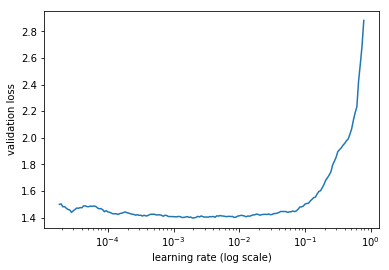

In [48]:
lrf=learn.lr_find()
learn.sched.plot()

In [52]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.448863   1.311074   0.534361  
    1      1.405124   1.303028   0.538767                   
    2      1.396005   1.306464   0.535683                   
    3      1.402845   1.303234   0.547137                   
    4      1.372364   1.297798   0.544934                   
    5      1.342952   1.290582   0.542731                   
    6      1.379837   1.28929    0.546696                   


[array([1.28929]), 0.5466960388395755]

In [53]:
learn.save('299_12cls_unf_bs48')

In [ ]:
learn.load('299_12cls_unf_bs48')

In [ ]:
learn.fit(lr, 10, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.372671   1.290845   0.547577  
    1      1.380739   1.278982   0.542291                   
    2      1.368688   1.279418   0.546696                   
    3      1.367094   1.272629   0.548018                   
    4      1.345491   1.272921   0.553304                   
    5      1.333466   1.267104   0.553744                   
    6      1.334859   1.264128   0.553304                   
    7      1.371418   1.269992   0.547137                   
    8      1.364804   1.263759   0.559031                   
    9      1.343403   1.25903    0.561674                   
    10     1.344066   1.254189   0.557269                   
    11     1.332897   1.248577   0.552423                   
    12     1.28492    1.243182   0.556388                   
    13     1.310286   1.241637   0.554185                   
    14     1.273155   1.241403   0.554626                   
    15     1.35625    1.242023   0.557269

This dataset is so similar to ImageNet dataset. Training convolution layers doesn't help much. We are not going to unfreeze.

## Create submission

https://youtu.be/9C06ZPF8Uuc?t=1905

In [ ]:
data.classes

In [ ]:
data.test_ds.fnames

In [ ]:
log_preds, y = learn.TTA(is_test=True) # use test dataset rather than validation dataset
probs = np.mean(np.exp(log_preds),0)
#accuracy_np(probs, y), metrcs.log_loss(y, probs) # This does not make sense since test dataset has no labels

In [ ]:
probs.shape # (n_images, n_classes)

In [ ]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [ ]:
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [ ]:
df.head()

In [ ]:
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [ ]:
FileLink(f'{SUBM}subm.gz')

## Individual prediction

In [ ]:
fn = data.val_ds.fnames[0]
fn

In [ ]:
Image.open(PATH + fn).resize((150, 150))

In [ ]:
# Method 1.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

In [ ]:
learn.data.classes[np.argmax(preds)]

In [ ]:
# Method 2.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
im = val_tfms(open_image(PATH + fn)) # open_image() returns numpy.ndarray
preds = learn.predict_array(im[None])
np.argmax(preds)